<a href="https://colab.research.google.com/github/kevin3302/fake-news-detection/blob/main/Fake_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports and Reading Data**

In [ ]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 5.6 MB/s eta 0:00:00


In [ ]:
from tqdm import tqdm
import re
import spacy
import nltk
import warnings
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import contractions
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
url = 'https://raw.githubusercontent.com/kevin3302/fake-news-detection/refs/heads/main/news.csv'
news = pd.read_csv(url, encoding="utf-8", on_bad_lines="warn")
news.reset_index(drop=True, inplace=True)

In [ ]:
news.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


# **Exploratory Data Analysis**

In [ ]:
news.shape

(6335, 4)

In [ ]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


### **Data Cleaning**

***'Unnamed: 0' and 'title' columns aren't necessary for model building as it doesn't contribute directly to the textual content used for classification. So let's drop them***

In [ ]:
news.drop(['Unnamed: 0', 'title'], axis=1, inplace=True)

In [ ]:
news.head()

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,It's primary day in New York and front-runners...,REAL


In [ ]:
news.isnull().sum()

,0
text,0
label,0


***There are no null values in the data***

In [ ]:
blank_rows = []
for index, text in news["text"].items():
    if text.isspace():
        blank_rows.append(index)
len(blank_rows)

36

***There are 36 rows in the text column in which there are just blank spaces and no other character, which may not be useful and should be removed as they provide no meaningful information for model training.***

In [ ]:
news.loc[blank_rows, ["text", "label"]].head()

,text,label
106,,FAKE
710,,FAKE
806,,FAKE
919,,FAKE
940,,FAKE


In [ ]:
news["text"][blank_rows[0]]

' '

In [ ]:
news.drop(blank_rows, inplace=True)

In [ ]:
news.shape

(6299, 2)

### **Class Distribution of Real vs Fake Data**

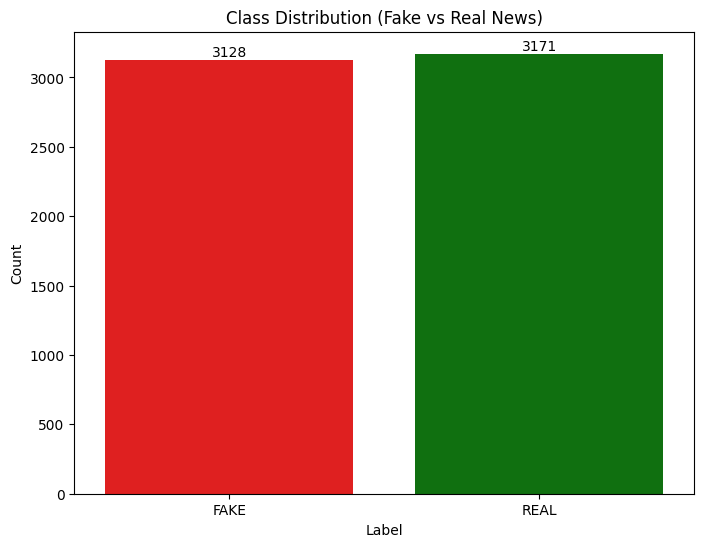

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='label', data=news, palette=['red', 'green'], hue='label')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Class Distribution (Fake vs Real News)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

***The data looks well balanced so there's no chance of bias***

### **Text length analysis (based on word count)**

In [ ]:
def text_length(text):
    if isinstance(text, str):
        return len(text.split())
    return 0

news['text_length'] = news['text'].apply(text_length)

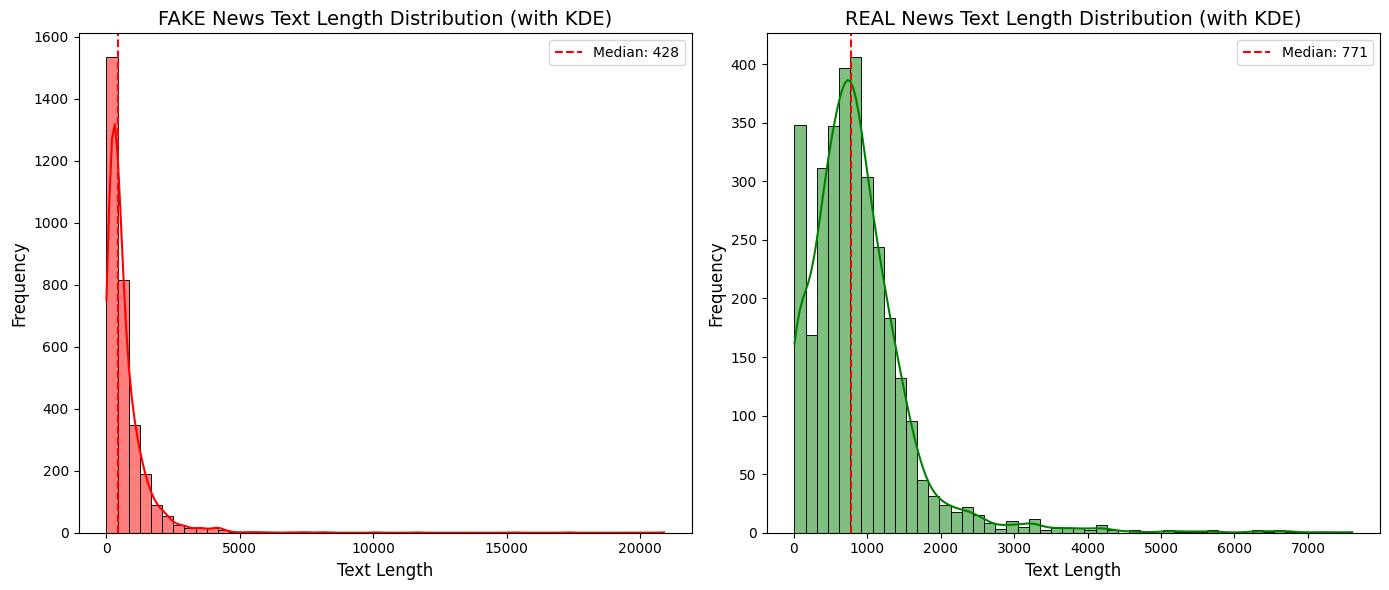

In [ ]:
plt.figure(figsize=(14, 6))

fake_median = news[news['label'] == 'FAKE']['text_length'].median()
real_median = news[news['label'] == 'REAL']['text_length'].median()

plt.subplot(1, 2, 1)
sns.histplot(news[news['label'] == 'FAKE']['text_length'], kde=True, color='red', bins=50)
plt.axvline(fake_median, color='red', linestyle='--', label=f'Median: {fake_median:.0f}')
plt.title("FAKE News Text Length Distribution (with KDE)", fontsize=14)
plt.xlabel("Text Length", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(news[news['label'] == 'REAL']['text_length'], kde=True, color='green', bins=50)
plt.axvline(real_median, color='red', linestyle='--', label=f'Median: {real_median:.0f}')
plt.title("REAL News Text Length Distribution (with KDE)", fontsize=14)
plt.xlabel("Text Length", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()

plt.tight_layout()

plt.show()

In [ ]:
std_devs = news.groupby('label')['text_length'].std()
print(std_devs)

label
FAKE    961.678654
REAL    722.483569
Name: text_length, dtype: float64


***The Text length distribution is positively skewed for both Fake and Real News. The median text length is higher for Real news (428) than Fake news (771), indicating that real news articles are generally longer. However, Fake news shows a wider spread(more standard deviation), suggesting that fake news can sometimes be longer than real news. This overlap in distributions indicates that text length is not a predictor for distinguishing between the two.***

In [ ]:
news.drop(columns=['text_length'], inplace=True)

### **Text Preprocessing**

***We normalize the text by converting it to lower case, expanding the contractions and cleaning the noise by removing the punctuations, consecutive whitespaces then perform lemmatization***

In [ ]:
nlp = spacy.load('en_core_web_sm')

# stop words from spacy
spacy_list = nlp.Defaults.stop_words
print(len(spacy_list))

# stop words from nltk
nltk_list = stopwords.words('english')
print(len(nltk_list))

# unique stop words list
Stopwords = set(spacy_list).union(set(nltk_list))
print(len(Stopwords))

326
198
401


In [ ]:
lemma = WordNetLemmatizer()

In [ ]:
def preprocess_text(text_data):
    preprocessed_text = []

    for sentence in tqdm(text_data):
        # convert text to lower case
        sentence = sentence.lower()
        # Expand contractions (e.g., "I'm" → "I am")
        sentence = contractions.fix(sentence)
        # remove punctuations
        sentence = re.sub(r'[^A-Za-z0-9\s]', ' ', sentence)
        # remove consecutive whitespaces
        sentence = re.sub(r'\s+', ' ', sentence)
        # Remove stop words + Lemmatization
        preprocessed_text.append(' '.join(
            lemma.lemmatize(token) for token in sentence.split()
            if token not in Stopwords
        ))

    return preprocessed_text

In [ ]:
preprocessed_review = preprocess_text(news['text'].values)
news['text'] = preprocessed_review

100%|██████████| 6299/6299 [00:23<00:00, 264.54it/s]


In [ ]:
news.head()

,text,label
0,daniel greenfield shillman journalism fellow f...,FAKE
1,google pinterest digg linkedin reddit stumbleu...,FAKE
2,secretary state john f kerry said monday stop ...,REAL
3,kaydee king kaydeeking november 9 2016 lesson ...,FAKE
4,primary day new york runner hillary clinton do...,REAL


### **Word Frequency Analysis**

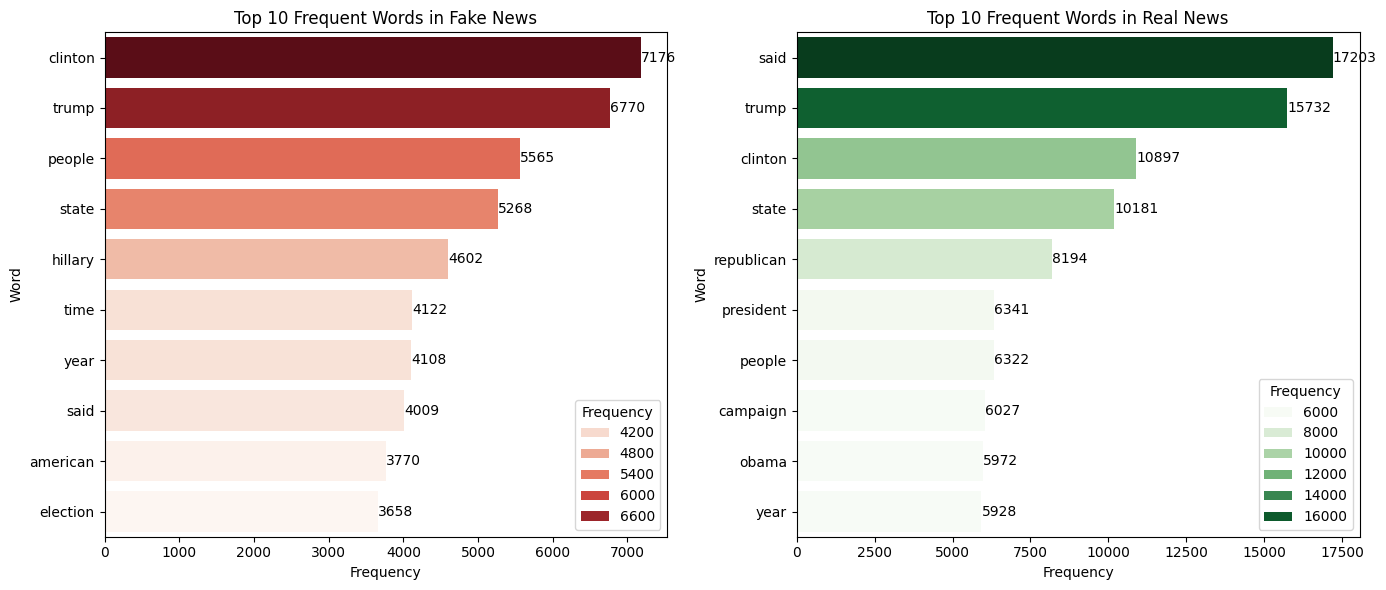

In [ ]:
def get_top_words(corpus, top_n=10):
    vectorizer = CountVectorizer(max_features=top_n)
    X = vectorizer.fit_transform(corpus)
    word_counts = X.sum(axis=0).A1
    words = vectorizer.get_feature_names_out()
    word_freq = pd.DataFrame(list(zip(words, word_counts)), columns=['Word', 'Frequency'])
    return word_freq.sort_values(by='Frequency', ascending=False).head(top_n)

fake_top_10 = get_top_words(news[news['label'] == 'FAKE']['text'], top_n=10)
real_top_10 = get_top_words(news[news['label'] == 'REAL']['text'], top_n=10)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x='Frequency', y='Word', data=fake_top_10, palette='Reds', hue='Frequency', ax=axes[0])
axes[0].set_title('Top 10 Frequent Words in Fake News')
axes[0].set_xlabel('Frequency')
for index, value in enumerate(fake_top_10['Frequency']):
    axes[0].text(value + 0.01, index, str(value), va='center', ha='left', color='black')

sns.barplot(x='Frequency', y='Word', data=real_top_10, palette='Greens', hue='Frequency', ax=axes[1])
axes[1].set_title('Top 10 Frequent Words in Real News')
axes[1].set_xlabel('Frequency')
for index, value in enumerate(real_top_10['Frequency']):
    axes[1].text(value + 0.01, index, str(value), va='center', ha='left', color='black')

plt.tight_layout()
plt.show()


***In fake news, the most frequent words are "clinton" (7,176 times) and "trump" (6,770 times), showing a strong focus on political figures. In real news, the top words are "said" (17,203 times) and "trump" (15,732 times), which suggests more reporting of statements or quotes. While these counts highlight political trends, the overlap—especially with "trump"—means that these words alone can't reliably separate fake from real news.***

### **N-Gram Analysis**

In [ ]:
def get_top_ngrams(corpus, ngram_range=(2, 2), n=10):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vectorizer.fit_transform(corpus)
    counts = X.sum(axis=0).A1
    vocab = vectorizer.get_feature_names_out()
    return Counter(dict(zip(vocab, counts))).most_common(n)

def plot_ngrams(fake_ngrams, real_ngrams, title):
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=False)

    for ax, ngrams, label, color in zip(
        axes,
        [dict(fake_ngrams), dict(real_ngrams)],
        ['Fake News', 'Real News'],
        ['red', 'green']
    ):
        keys = list(ngrams.keys())
        values = list(ngrams.values())
        bars = ax.barh(keys, values, color=color)
        ax.set_title(f'Top 10 {title} in {label}')
        ax.set_xlabel('Frequency')
        ax.invert_yaxis()

        for bar in bars:
            width = bar.get_width()
            ax.text(width + max(values)*0.01, bar.get_y() + bar.get_height()/2,
                    f'{int(width)}', va='center', ha='left', fontsize=10)

    plt.tight_layout()
    plt.show()

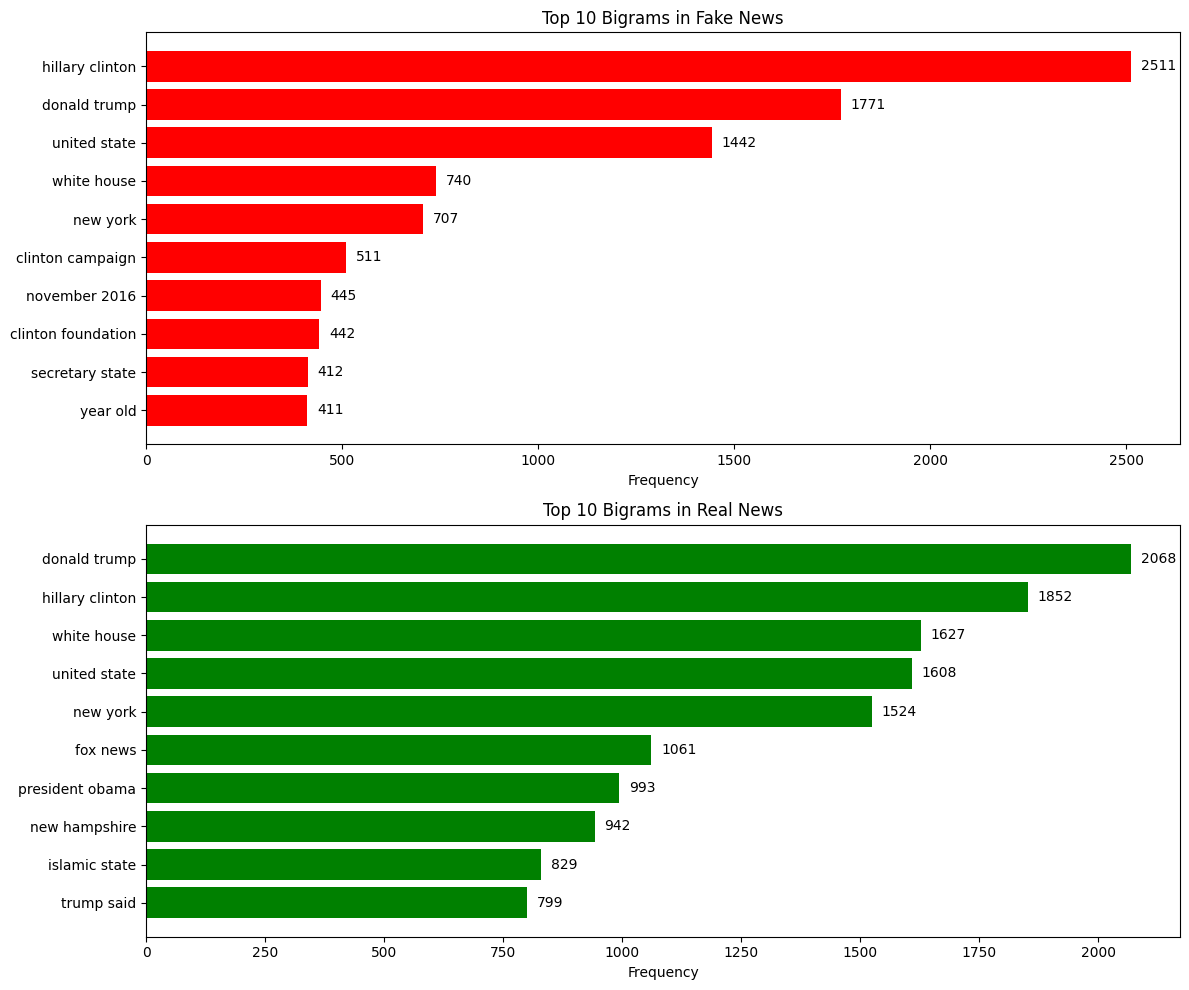

In [ ]:
fake_bigrams = get_top_ngrams(news[news['label'] == 'FAKE']['text'], ngram_range=(2, 2))
real_bigrams = get_top_ngrams(news[news['label'] == 'REAL']['text'], ngram_range=(2, 2))
plot_ngrams(fake_bigrams, real_bigrams, 'Bigrams')

***Top bigrams show both fake and real news focus on names like "donald trump" and "hillary clinton." However, real news has neutral terms like "white house" or phrases like "trump said," pointing to reporting. Fake news leans toward phrases like "clinton campaign" or "november 2016," hinting at a more narrative or election-focused angle (Possibly 2016 Presidential Election Campaign)***

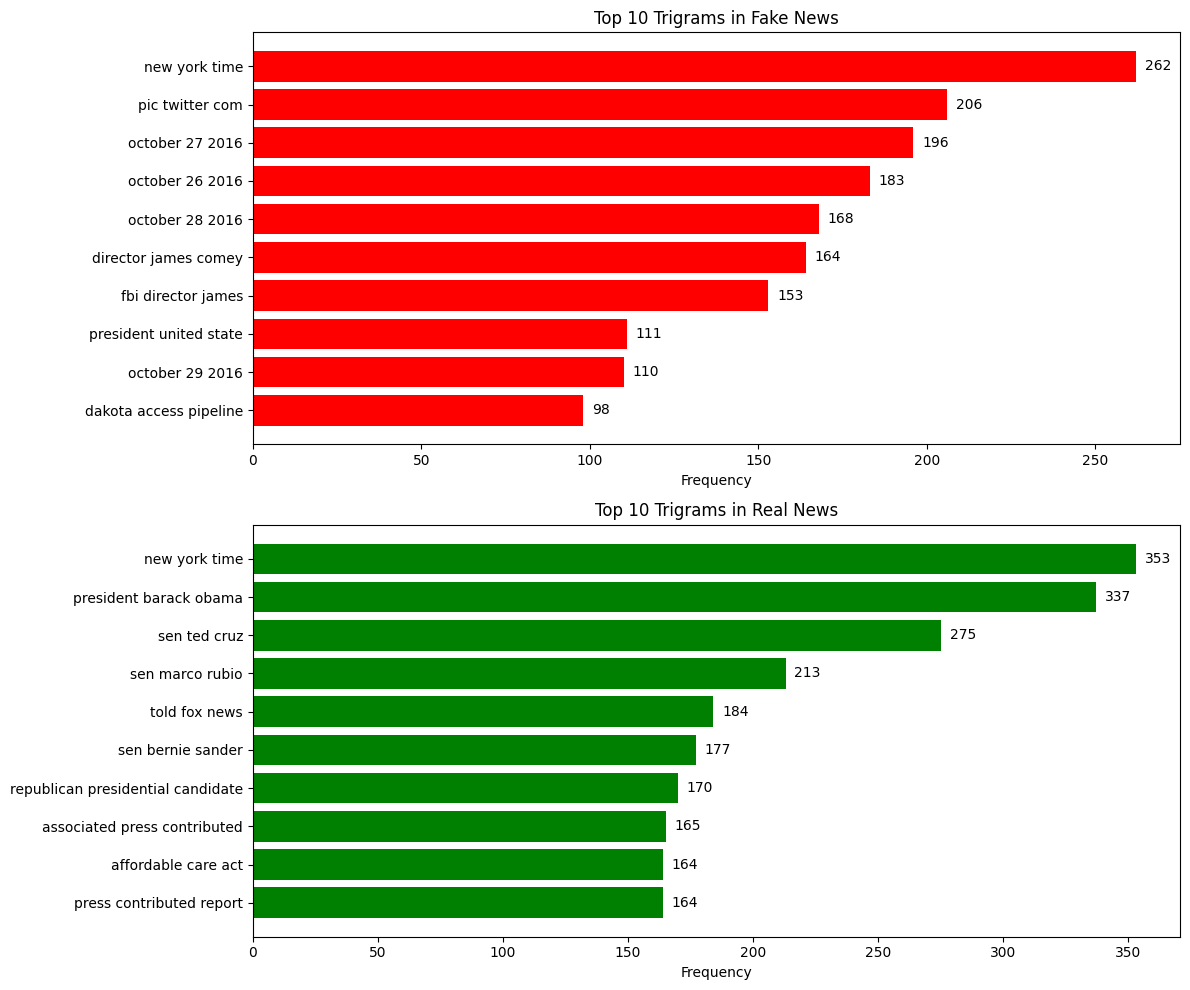

In [ ]:
fake_trigrams = get_top_ngrams(news[news['label'] == 'FAKE']['text'], ngram_range=(3, 3))
real_trigrams = get_top_ngrams(news[news['label'] == 'REAL']['text'], ngram_range=(3, 3))
plot_ngrams(fake_trigrams, real_trigrams, 'Trigrams')

***Top trigrams show "new york time" is frequent in both, but fake news emphasizes specific October 2016 dates (around 170-200 frequency) and "director james comey" (around 160), suggesting a focus on a particular timeframe and individual. Real news, besides "new york time," highlights "president barack obama" (337) and various senators (Ted Cruz, Marco Rubio, Bernie Sanders around 170-275), indicating broader political reporting on key figures.***

### **Sentiment Analysis**

In [ ]:
analyzer = SentimentIntensityAnalyzer()

news['compound_score'] = news['text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [ ]:
def get_sentiment_category(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

news['sentiment_category'] = news['compound_score'].apply(get_sentiment_category)

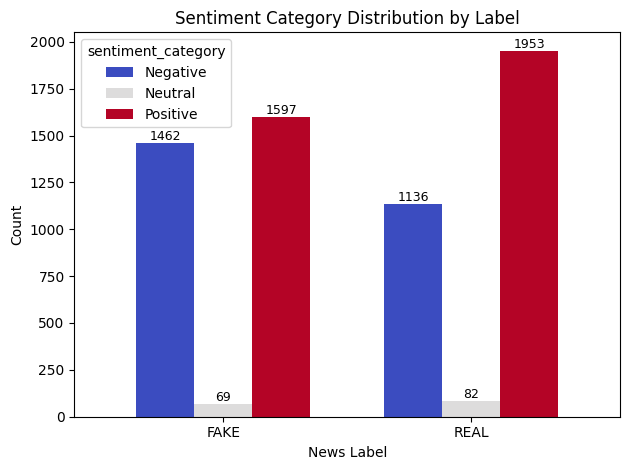

In [ ]:
sentiment_dist = news.groupby(['label', 'sentiment_category']).size().unstack()

ax = sentiment_dist.plot(kind='bar', colormap='coolwarm', width=0.7)

plt.title("Sentiment Category Distribution by Label")
plt.ylabel("Count")
plt.xlabel("News Label")

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(str(int(height)),
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=9, color='black')

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

***Sentiment analysis shows that most of the fake and real news articles tend to be either negative or positive, with fewer neutral articles. Fake news has more negative articles (1462) than real (1136), while real news has more positive ones (1953 vs. 1597). This suggests that fake news leans more toward negative framing, whereas real news tends to carry a more positive tone overall.***

# **Model Training**

In [ ]:
le = LabelEncoder()
news['label'] = le.fit_transform(news['label'])

tfidf = TfidfVectorizer(
    ngram_range=(1, 3),
    stop_words='english'
)
X_tfidf = tfidf.fit_transform(news['text'])
y = news['label']

In [ ]:
news.head()
# FAKE - 0, REAL - 1

,text,label,compound_score,sentiment_category
0,daniel greenfield shillman journalism fellow f...,0,-0.9994,Negative
1,google pinterest digg linkedin reddit stumbleu...,0,0.8887,Positive
2,secretary state john f kerry said monday stop ...,1,0.7269,Positive
3,kaydee king kaydeeking november 9 2016 lesson ...,0,-0.3818,Negative
4,primary day new york runner hillary clinton do...,1,0.9779,Positive


In [ ]:
X_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 6329450 stored elements and shape (6299, 3651622)>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.25, random_state=42, stratify=y
)

### **Logistic Regression**

In [ ]:
model = LogisticRegression(solver='liblinear', random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_f1_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
print(f"Cross-Validation F1: {np.mean(cv_f1_scores):.3f} ± {np.std(cv_f1_scores):.3f}")

Cross-Validation F1: 0.890 ± 0.014


In [ ]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

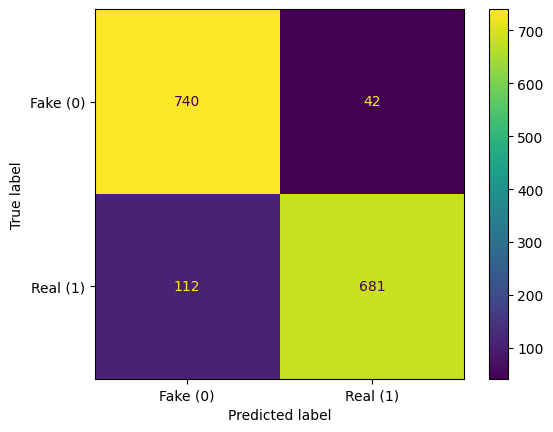

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=['Fake (0)', 'Real (1)'])

cm_display.plot()
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, target_names=['Fake (0)', 'Real (1)']))

              precision    recall  f1-score   support

    Fake (0)       0.87      0.95      0.91       782
    Real (1)       0.94      0.86      0.90       793

    accuracy                           0.90      1575
   macro avg       0.91      0.90      0.90      1575
weighted avg       0.91      0.90      0.90      1575



### **Support Vector Machines**

In [ ]:
svm_model = SVC(kernel='linear', random_state=42)

# Cross-validation
svm_cv_scores = cross_val_score(svm_model, X_train, y_train, cv=cv, scoring='f1')
print(f"CV F1 (SVM): {np.mean(svm_cv_scores):.3f} ± {np.std(svm_cv_scores):.3f}")

CV F1 (SVM): 0.922 ± 0.009


In [ ]:
# Train and evaluate
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

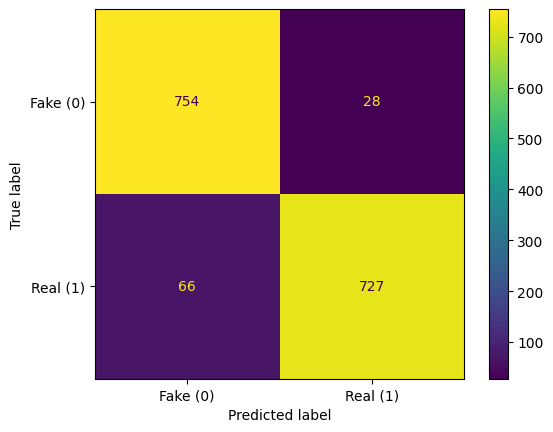

In [ ]:
cm = confusion_matrix(y_test, svm_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=['Fake (0)', 'Real (1)'])

cm_display.plot()
plt.show()

In [ ]:
print(classification_report(y_test, svm_pred, target_names=['Fake (0)', 'Real (1)']))

              precision    recall  f1-score   support

    Fake (0)       0.92      0.96      0.94       782
    Real (1)       0.96      0.92      0.94       793

    accuracy                           0.94      1575
   macro avg       0.94      0.94      0.94      1575
weighted avg       0.94      0.94      0.94      1575



# **References**

***References:*** <br>

<ul>
<li> <a href="https://towardsdatascience.com/fundamental-eda-techniques-for-nlp-f81a93696a75/">https://towardsdatascience.com/fundamental-eda-techniques-for-nlp-f81a93696a75/</a></li>
<li><a href="https://medium.com/data-science/intermediate-eda-techniques-for-nlp-2c898cc96d1d">https://medium.com/data-science/intermediate-eda-techniques-for-nlp-2c898cc96d1d</a></li>
<li><a href="https://www.geeksforgeeks.org/fake-news-detection-using-machine-learning/">https://www.geeksforgeeks.org/fake-news-detection-using-machine-learning/</a></li>
<li><a href="https://jessica-miles.medium.com/adding-annotations-to-visualizations-using-matplotlib-279e9c770baa">https://jessica-miles.medium.com/adding-annotations-to-visualizations-using-matplotlib-279e9c770baa</a></li>
</ul>
